In [1]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from utils import *

MODELS_PATH = './models'
DATA_PATH = './data/'
dataset = 'adult'
seed = 1
np.random.seed(seed)

C:\Users\Eli\Anaconda3\envs\tf1\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
from ctgan import load_demo
data = load_demo()

categorical_features = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
]

data = data.drop(columns=categorical_features)

In [4]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features = []
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.810


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)
X_test = X_test[1:]
y_test = y_test[1:]

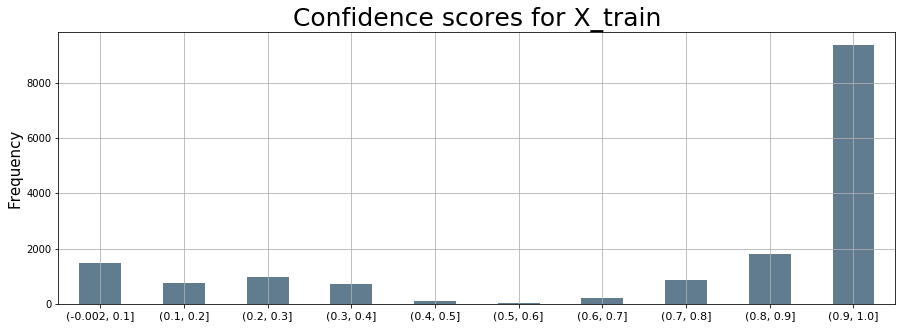

In [7]:
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

In [8]:
clf.fit(X_test, y_test)
y_prob_test = clf.predict_proba(X_test)
y_conf_test = y_prob_test[:, 0]  # confidence scores

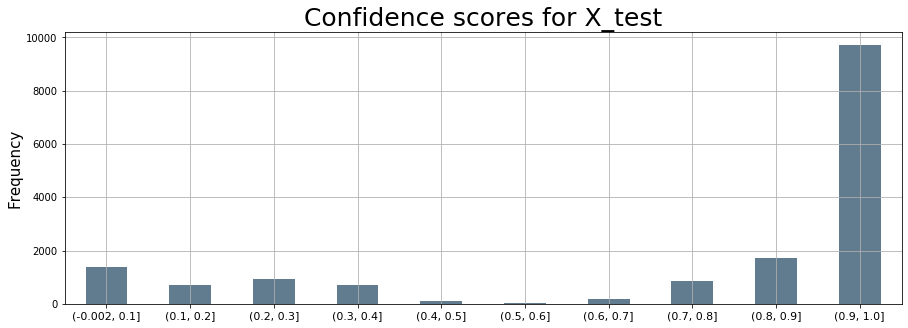

In [9]:
plot_confidence_levels(y_conf_test, "Confidence scores for X_test")

In [10]:
# Create bucket (intervals) from generated data
top_c = 10
conf_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values

# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]
top_c_lst = sorted(round(x, 4) for x in top_c_lst)

In [11]:
top_c_lst 

[0.049, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [17]:
# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all 
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)
c = 0.95
    
# train CTGAN
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
confidence_level = c
gen_lr = 2e-5
loss = 'log'


rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss
                            )

print(f"Training CTGAN for c = {c}...")
hist = rf_ctgan.fit(train_data=z,
                    epochs=epochs,
                    confidence_level=confidence_level,
                    gen_lr=gen_lr,
                    verbose=False
                    )

# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
# plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
# print()


print("\tGenerate samples to same dist...")
# Generate samples to same dist
samples = 100000
gen_data = rf_ctgan.sample(samples)

y_prob = rf.predict_proba(gen_data)
y_conf_gen = y_prob[:, 0]  # confidence scores

# ans is the indices of gen_data to make the same dist 
ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
gen_data_same_dist = gen_data.iloc[ans]
y_conf_gen_same_dist = y_conf_gen[ans]

# inverse the generated data
scaler = get_scaler(preprocessor)
gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
gen_data_inv = pd.DataFrame(gen_data_inv)

print(f"\tWorking on results...")
print(f"\tResults for confidence level = {c}")

Training CTGAN for c = 0.95...
	Generate samples to same dist...
	Working on results...
	Results for confidence level = 0.95


In [18]:
gen_data_inv

,0,1,2,3,4,5
0,9.931502,-347.381663,230793.864158,7591.842372,6.962344,39.601714
1,25.325245,766.033962,-7212.558726,16394.120210,12.026028,24.774688
2,40.588387,-44.183203,219574.994356,-9553.130144,7.243487,6.980122
3,24.620979,-1432.405754,262602.711594,-5552.602865,4.596430,9.200947
4,62.864073,39.516179,337203.625965,-8538.552453,7.224852,32.567549
...,...,...,...,...,...,...
16275,55.326376,-711.827006,92343.415069,8268.819570,7.892963,13.608649
16276,64.820498,747.808394,202025.411883,-9882.431871,11.939617,28.492477
16277,52.797470,-647.462513,364167.005606,12055.167349,9.573660,2.763058
16278,33.287236,162.058542,287658.189973,9500.989104,12.147803,31.527091


In [22]:
train_results = table(gen_data_inv, X_train_pd, y_conf_gen_same_dist, y_conf_train)

In [23]:
test_results = table(gen_data_inv, X_test_pd, y_conf_gen_same_dist, y_conf_test)

In [24]:
display_side_by_side(train_results, test_results)

,0.01,0.05,0.1,0.15,0.2
0.80,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0,0.0123 | 0.0,0.0123 | 0.0
0.85,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0
0.90,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0
0.95,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0,0.0061 | 0.0
0.99,0.0 | 0.0,0.0 | 0.0,0.0 | 0.0,0.0 | 0.0,0.0 | 0.0
,0.01,0.05,0.1,0.15,0.2
0.80,0.0 | 0.3194,0.0553 | 0.3194,0.0983 | 0.3194,0.0983 | 0.3194,0.0983 | 0.3194
0.85,0.0 | 0.2396,0.0184 | 0.2396,0.0799 | 0.2396,0.0799 | 0.2396,0.0799 | 0.2396
0.90,0.0 | 0.1843,0.0 | 0.1843,0.0553 | 0.1843,0.0553 | 0.1843,0.0553 | 0.1843
0.95,0.0 | 0.086,0.0 | 0.086,0.0246 | 0.086,0.0246 | 0.086,0.0246 | 0.086
